# Pipeline for CT Scan Analysis using Otsu Method

In [1]:
# imports
import scipy
import numpy as np
import pandas as pd
import random
from PIL import Image, ImageOps
from copy import copy, deepcopy
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import os
import glob
from PIL import Image, ImageOps
from scipy import ndimage, misc
import scipy.misc
from skimage.restoration import denoise_tv_chambolle
from sklearn.mixture import GaussianMixture
import statistics
from skimage import data
from skimage.filters import threshold_multiotsu
from tqdm import tqdm
from os.path import exists
import seaborn
import os

## Functions

In [2]:
def median_filter(image, kernel_size):
    """Apply a median filter to an image.
    
    Parameters
    ----------
    image : array_like
        Input image.
    kernel_size : int
        Size of the median filter kernel.
    
    Returns
    -------
    image_filtered : array_like
        Filtered image.
    """

    assert kernel_size % 2 == 1 # Kernel size must be odd
    assert kernel_size > 1 #Kernel size must be greater than 1

    return scipy.ndimage.median_filter(image, kernel_size)

In [3]:
# load in image
def image_loader(path, pt_num,im_num, seg = True):
    im = cv2.imread(path + pt_num + '/brain/' + im_num + '.jpg',0) 
    bone = cv2.imread(path + pt_num + '/bone/' + im_num + '.jpg',0)
    if seg == True: 
        gt = cv2.imread(path + pt_num + '/brain/' + im_num + '_HGE_Seg.jpg')
    else: 
        gt = 0
    return im, bone, gt

In [4]:
def histogram_eq(im):
    clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(5,5))
    he_im = clahe.apply(im) # apply the histogram equalization to the image (im)
    return he_im

In [5]:
def grey_matter_sub(med_im):
    flat_med_im = med_im.flatten()
    max_intens = statistics.mode(flat_med_im)
    #max_intens = np.max(flat_med_im)

    mask = (med_im != max_intens)
    #mask2 = (med_im != 255)
    #gms_im = med_im*mask*mask2
    gms_im = med_im*mask
    return gms_im

In [6]:
def multi_otsu(im, classes = 5, gauss = 1, thres = 3, blur = True):
    if blur == True:
        image = ndimage.gaussian_filter(im, gauss)
    else:
        image = im
    # Applying multi-Otsu threshold for the default value
    thresholds = threshold_multiotsu(image, classes=classes)
    if thres != 0:
        thresholds = thresholds[thres:]
    # Using the threshold values, we generate the three regions.
    regions = np.digitize(image, bins=thresholds)
    return regions

In [7]:
def analysis(answer,brain_no_bones):
    tn = 0
    tp = 0
    fn = 0
    fp = 0
    answer = cv2.cvtColor(answer, cv2.COLOR_BGR2GRAY)
    for w in range(brain_no_bones.shape[0]): 
        for h in range(brain_no_bones.shape[1]): 
            if brain_no_bones[w,h] == 0 and answer[w,h] == 0: 
                tn += 1
            elif brain_no_bones[w,h] == 1 and answer[w,h] == 255: 
                tp += 1
            elif brain_no_bones[w,h] == 0 and answer[w,h] == 255: 
                fn += 1
            elif brain_no_bones[w,h] == 1 and answer[w,h] == 0: 
                fp += 1
    return tn, tp, fn, fp

In [8]:
threshold_num = round(422500*0.015)
def flag_it(brain_no_bones, threshold =  threshold_num): 
    look = 0
    concern = False; 
    # threshold is 10% of pixels in the image
    for w in range(brain_no_bones.shape[0]): 
        for h in range(brain_no_bones.shape[1]):
            if brain_no_bones[w,h] == 1: 
                look+=1
    
    if look > threshold: 
        concern = True
        
    return concern

# Analysis on Accuracy of Pixel Detection for a small subset of known TBI scans

In [9]:
path = '/Users/amandabreton/Documents/Duke 2022-2023/ECE 588/CTscans/Patients_CT/'
scans = {'049':[15,16,17],'050':[18,21,22]}
total_tn = 0
total_tp = 0
total_fn = 0
total_fp = 0
for p in tqdm(scans):
    for i in scans[p]:
        im, bone, gt = image_loader(path, str(p), str(i))
        he_im = histogram_eq(im)
        med_im = median_filter(he_im,3)
        gms_im = grey_matter_sub(med_im)
        tv_im = denoise_tv_chambolle(gms_im, weight=0.25)
        tv_im = np.round(tv_im*255)
        regions = multi_otsu(tv_im)
        new = regions*tv_im
        regions = multi_otsu(new, classes = 3, thres = 0, blur = False)
        bone_mask = multi_otsu(bone, classes = 3, gauss = 5, thres = 1)
        bone_mask=(bone_mask==0)
        brain_no_bones = regions * bone_mask
        tn, tp, fn, fp = analysis(gt,brain_no_bones)
        print('TP:' + str(tp) + ', TN: ' + str(tn) + ', FP: ' + str(fp) + ', FN: ' + str(fn))
        total_tn += tn
        total_tp += tp
        total_fn += fn
        total_fp += fp

  0%|                                                | 0/2 [00:00<?, ?it/s]

TP:1003, TN: 400971, FP: 12260, FN: 412
TP:691, TN: 399501, FP: 11628, FN: 674


 50%|████████████████████                    | 1/2 [00:24<00:24, 24.93s/it]

TP:439, TN: 403809, FP: 10617, FN: 852
TP:133, TN: 408659, FP: 9553, FN: 1054
TP:222, TN: 407841, FP: 9693, FN: 519


100%|████████████████████████████████████████| 2/2 [00:49<00:00, 24.74s/it]

TP:165, TN: 410445, FP: 8314, FN: 275


[Text(0.5, 15.0, 'Actual'),
 Text(33.0, 0.5, 'Predicted'),
 [Text(0.5, 0, 'Positive'), Text(1.5, 0, 'Negative')],
 [Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Negative')],
 Text(0.5, 1.0, 'Confusion Matrix Percentage of All Pixels')]

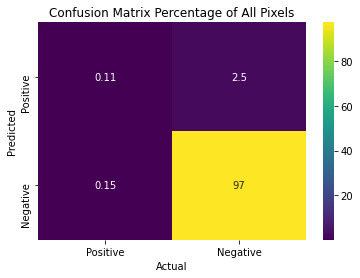

In [10]:
div_tp = 100*(total_tp/(total_tp+total_fp+total_fn+total_tn))
div_fp = 100*(total_fp/(total_tp+total_fp+total_fn+total_tn))
div_fn = 100*(total_fn/(total_tp+total_fp+total_fn+total_tn))
div_tn = 100*(total_tn/(total_tp+total_fp+total_fn+total_tn))

data = [[div_tp, div_fp],[div_fn, div_tn]]
ax = seaborn.heatmap(data, annot = True, cmap = 'viridis')
ax.set(xlabel="Actual", ylabel="Predicted", xticklabels=['Positive', 'Negative'], 
       yticklabels=['Positive', 'Negative'], title = 'Confusion Matrix Percentage of All Pixels')

In [11]:
recall = total_tp/(total_tp+total_fn) # how often is it positive when it should be positive 
false_pos_rate = total_fp/(total_fp+total_tn) 
# how often is it wrong about being positive when it should be negative 
precision = total_tp/(total_tp+total_fp) 
true_neg_rate = total_tn/(total_tn+total_fn)

print("tp = {0},tn = {1}, fp = {2}, fn = {3})".format(total_tp,total_tn,total_fp,total_fn))
print('recall = {0}'.format(recall))
print('precision = {0}'.format(precision))
print('true negative rate = {0}'.format(true_neg_rate))
print('false positive rate = {0}'.format(false_pos_rate))

tp = 2653,tn = 2431226, fp = 62065, fn = 3786)
recall = 0.4120205000776518
precision = 0.04099323217651967
true negative rate = 0.9984451822003342
false positive rate = 0.02489280232431754


# Analysis on a large set of CT scans for multiple images
Want to see if we can clean the dataset so doctors only need to look at flagged CT scans

### Getting the list of patients and images 

In [12]:
path = '/Users/amandabreton/Documents/Duke 2022-2023/ECE 588/CTscans/Patients_CT/'
patients = os.listdir(path)

# removing all the .DS store files!!
if os.path.exists(os.path.join(path, ".DS_Store")):
    os.remove(os.path.join(path, ".DS_Store"))
#else:
    # print("no .DS_Store files")
#    pass
path = '/Users/amandabreton/Documents/Duke 2022-2023/ECE 588/CTscans/Patients_CT/'
patients = os.listdir(path)

for p in patients:
    if p != '.DS_Store':
        all_image_list = os.listdir(path+p+'/brain')
    
question_list = []
for s in all_image_list: 
    if not 'HGE_Seg' in str(s): 
        ick = s.split('.')
        question_list.append(ick[0])

print(patients)        

['049', '054', '053', '052', '055', '050', '057', '056', '051', '058']
['049', '054', '053', '052', '055', '050', '057', '056', '051', '058']


### Running the analysis on the folder of patients

# DO NOT RUN THE NEXT BOX UNLESS YOU HAVE HOURS TO WAIT FOR NUMERIC RESULTS 

In [13]:
tp = 0 #concern = true, seg = true 
fp = 0 # concern = true, seg = false 
tn = 0 # concern = False, seg = false 
fn = 0 # concern = false, seg = true 

for p in patients:
    print('Patient: '+ p)
    if p != '.DS_Store':
        all_image_list = os.listdir(path+p+'/brain')
    question_list = []
    for s in all_image_list: 
        if not 'HGE_Seg' in str(s): 
            ick = s.split('.')
            question_list.append(ick[0])
    for i in question_list:
        #print('Patient: ' + p + ' Image: ' + i)
        im, bone, gt = image_loader(path, p, i,seg=False)
        he_im = histogram_eq(im)
        med_im = median_filter(he_im,3)
        gms_im = grey_matter_sub(med_im)
        tv_im = denoise_tv_chambolle(gms_im, weight=0.25)
        tv_im = np.round(tv_im*255)
        regions = multi_otsu(tv_im)
        new = regions*tv_im
        regions = multi_otsu(new, classes = 3, thres = 0, blur = False)
        bone_mask = multi_otsu(bone, classes = 3, gauss = 5, thres = 1)
        bone_mask=(bone_mask==0)
        brain_no_bones = regions * bone_mask
        concern = flag_it(brain_no_bones)
        path_to_file = path + p + '/brain/' + i + '_HGE_Seg.jpg'
        file_exists = exists(path_to_file)
        if concern == True and file_exists == True: 
            tp +=1 
        elif concern == True and file_exists == False: 
            fp += 1
        elif concern == False and file_exists == False: 
            tn +=1 
        else: # concern == False and file_exists == True
            fn += 1         

Patient: 049
Patient: 054
Patient: 053
Patient: 052
Patient: 055
Patient: 050
Patient: 057
Patient: 056
Patient: 051
Patient: 058


In [14]:
print(patients)

['049', '054', '053', '052', '055', '050', '057', '056', '051', '058']


## Analytic Results

tp = 50,tn = 125, fp = 130, fn = 11)
accuracy = {0}.format(accuracy)
0.5537974683544303


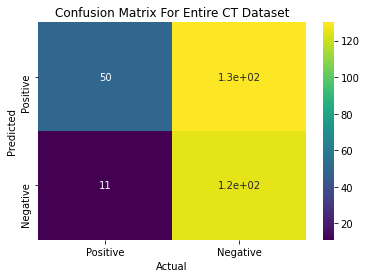

<Figure size 432x288 with 0 Axes>

In [15]:
print("tp = {0},tn = {1}, fp = {2}, fn = {3})".format(tp,tn,fp,fn))

recall = tp/(tp+fn) # how often is it positive when it should be positive 
false_pos_rate = fp/(fp+tn) 
# how often is it wrong about being positive when it should be negative 
precision = tp/(tp+fp) 
#true_neg_rate = tn/(tn+fn)
accuracy = (tp + tn)/(tp+tn+fp+fn)
print("accuracy = {0}.format(accuracy)")
print(accuracy)
# confusion matrix 
data = [[tp, fp],[fn, tn]]

ax = seaborn.heatmap(data, annot = True, cmap = 'viridis')
ax.set(xlabel="Actual", ylabel="Predicted", xticklabels=['Positive', 'Negative'], 
       yticklabels=['Positive', 'Negative'], title = 'Confusion Matrix For Entire CT Dataset')

plt.show()
plt.savefig('Confusion Matrix.png')

# The following is the breakdown of analysis on a single image
## Pipeline is: 
### Pre-processing: histogram equalization --> median filter/gray matter subtraction --> total variation
### Segmentation: Otsu's method a bunch
### Post-processing: comparing the results and removing the bones

# Load the Image(s)

In [45]:
# load in every image in a given folder

path = '/Users/amandabreton/Documents/Duke 2022-2023/ECE 588/CTscans/Patients_CT/'  # point to correct folder

# cur_num represents patient number - used for finding them in directory
cur_num = 49
images = []

# 81 patients in total
for patient in range(81):
    # get filenames for each patient
    filenames = glob.glob(path + "0" + str(cur_num) + "/brain/" + "*.jpg")

    # get each scan for each patient
    for f in filenames:

        # read in the image
        img = cv2.imread(f)
        images.append(img)
        # convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        #print(Image.fromarray(img))

        cur_num += 1
# to access each image: plt.imshow(images[50], cmap='gray')

# Single Raw Image 

(-0.5, 649.5, 649.5, -0.5)

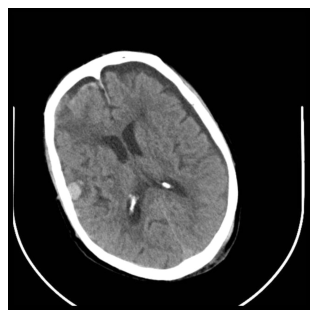

In [46]:
figure(figsize=(5, 5), dpi=80)
im = plt.imread(path+ '092/brain/20.jpg')
plt.imshow(im, cmap='gray')
plt.axis('off')

# Preprocessing

## Histogram Equalization
for presentation, maybe display histograms of not equalized and equalized 

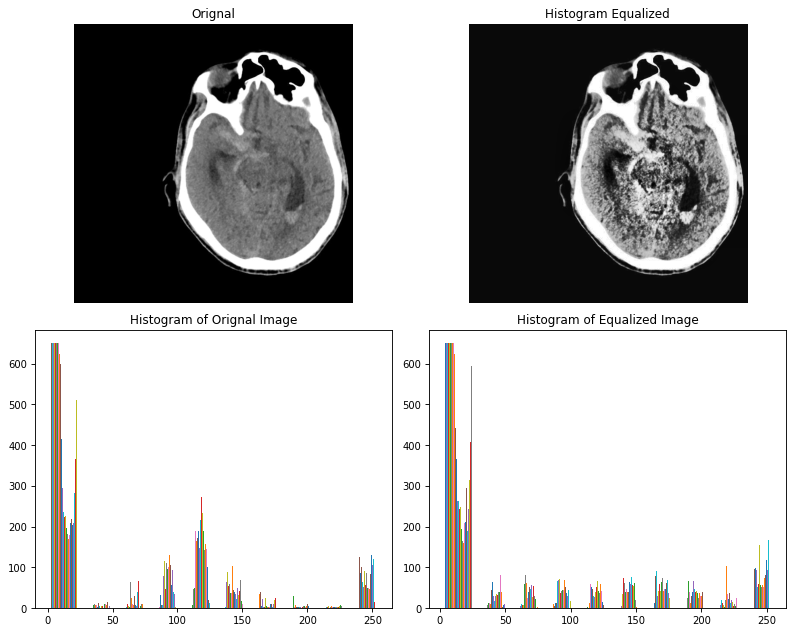

In [54]:
#im = cv2.imread(path+ '092/brain/20.jpg',0) # YOU NEED THE 0 IN FOR THIS TO WORK 
#bone = cv2.imread(path+ '092/bone/20.jpg',0)
#im = cv2.imread(path+ '069/brain/18.jpg',0) 
#bone = cv2.imread(path+ '069/bone/18.jpg',0)

im = cv2.imread(path+ '080/brain/14.jpg',0) 
bone = cv2.imread(path+ '080/bone/14.jpg',0)
answer = cv2.imread(path+ '080/brain/14_HGE_Seg.jpg')

# CLAHE (Contrast Limited Adaptive Histogram Equalization)
# special histogram equalization where picture is broken up into blocks, equalized separately, 
# and then put back together
clahe = cv2.createCLAHE(clipLimit=10.0, tileGridSize=(5,5))
he_im = clahe.apply(im) # apply the histogram equalization to the image (im)

figure(figsize=(10, 8), dpi=80)
plt.subplot(2,2,1)
plt.imshow(im, cmap='gray')
plt.title('Orignal')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(he_im, cmap = 'gray')
plt.title('Histogram Equalized')
plt.axis('off')
plt.subplot(2,2,3)
plt.hist(im)
plt.title("Histogram of Orignal Image")
plt.subplot(2,2,4)
plt.hist(he_im)
plt.title("Histogram of Equalized Image")
plt.tight_layout()
plt.savefig('Histogram Equalization.png')

## Median Filter 

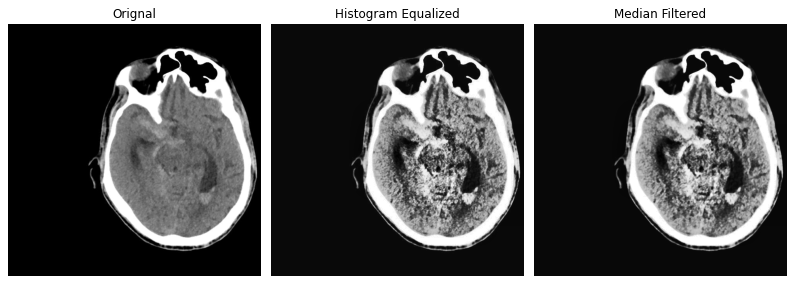

In [48]:
figure(figsize=(10, 8), dpi=80)
#previous images
plt.subplot(1,3,1)
plt.imshow(im, cmap='gray')
plt.title('Orignal')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(he_im, cmap = 'gray')
plt.title('Histogram Equalized')
plt.axis('off')

# median filter
med_im = median_filter(he_im,3)
plt.subplot(1,3,3)
plt.imshow(med_im, cmap='gray')
plt.title('Median Filtered')
plt.axis('off')
plt.tight_layout()


### Exploration: Median Filtered Image - Orignal 

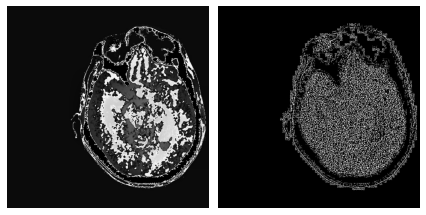

In [49]:
plt.subplot(1,2,1)
plt.imshow(med_im-im, cmap = 'gray')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(med_im-he_im, cmap = 'gray')
plt.axis('off')
plt.tight_layout()

## Gray matter subtraction (GMS): 
In this stage the gray matter intensity is removed from the image by subtracting the maximum intensity level of the histogram from the image. 

(-0.5, 649.5, 649.5, -0.5)

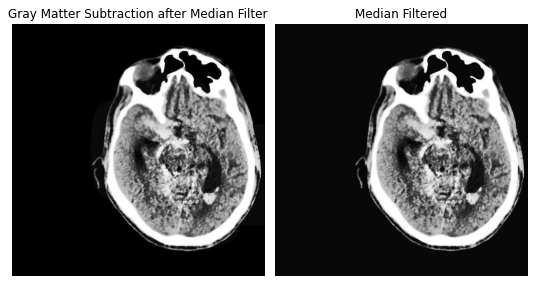

In [50]:
flat_med_im = med_im.flatten()
max_intens = statistics.mode(flat_med_im)

mask = (med_im != max_intens)
gms_im = med_im*mask
figure(figsize=(10, 8), dpi=80)
plt.subplot(1,3,1)
plt.imshow(gms_im, cmap = 'gray')
plt.axis('off')
plt.tight_layout()
plt.title('Gray Matter Subtraction after Median Filter')

plt.subplot(1,3,2)
plt.imshow(med_im, cmap='gray')
plt.title('Median Filtered')
plt.axis('off')

## Total Variation 

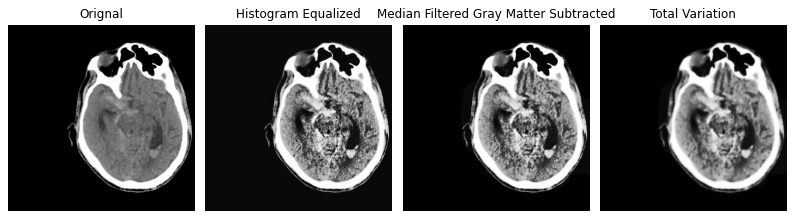

In [51]:
figure(figsize=(10, 8), dpi=80)
#previous images
plt.subplot(1,4,1)
plt.imshow(im, cmap='gray')
plt.title('Orignal')
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(he_im, cmap = 'gray')
plt.title('Histogram Equalized')
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(gms_im, cmap='gray')
plt.title('Median Filtered Gray Matter Subtracted')
plt.axis('off')

# total variation
tv_im = denoise_tv_chambolle(gms_im, weight=0.25)
# The greater weight, the more denoising (at the expense of fidelity to input).
plt.subplot(1,4,4)
plt.title('Total Variation')
plt.imshow(tv_im, cmap='gray')
plt.axis('off')
plt.tight_layout()
tv_im = np.round(tv_im*255)
plt.savefig('ComparingSteps.png')

### histogram of total variation

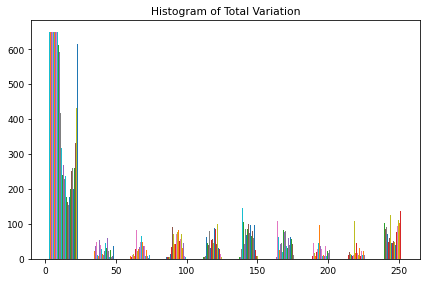

In [52]:
plt.hist(tv_im)
plt.title("Histogram of Total Variation")
plt.tight_layout()

### How total variation changed from original image and last step 

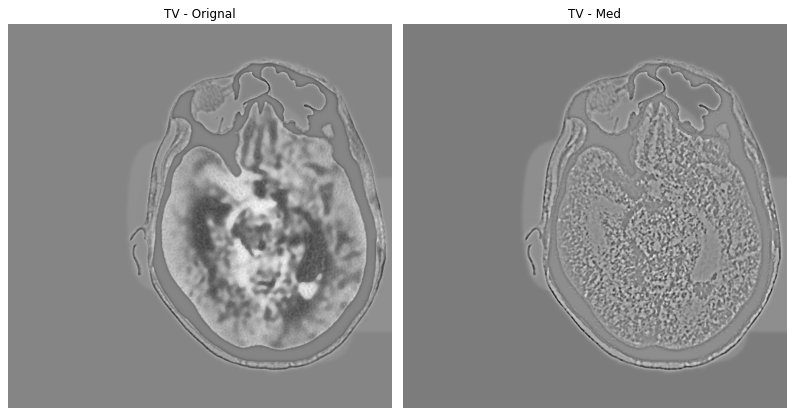

In [53]:
figure(figsize=(10, 8), dpi=80)
plt.subplot(1,2,1)
plt.imshow(tv_im-im, cmap = 'gray')
plt.title('TV - Orignal')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(tv_im-med_im, cmap = 'gray')
plt.title('TV - Med')
plt.axis('off')
plt.tight_layout()

# Segmentation Using Otsu's Method (single)

threshold is 88.0


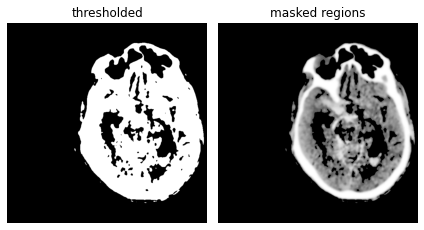

In [30]:
# don't need to convert to gray because we did that earlier 
#gray = cv2.cvtColor(tv_im, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(tv_im, (7, 7), 0)
blurred = np.asarray(blurred, dtype = 'uint8')
(T, threshInv) = cv2.threshold(blurred, np.min(blurred), np.max(blurred),cv2.THRESH_OTSU)
print('threshold is ' + str(T))
plt.subplot(1,2,1)
plt.imshow(threshInv, cmap = 'gray')
plt.axis('off')
plt.title('thresholded')
plt.subplot(1,2,2)
## visualize only the masked regions in the image
masked = cv2.bitwise_and(blurred, blurred, mask=threshInv)
plt.imshow(masked, cmap = 'gray')
plt.title('masked regions')
cv2.waitKey(0)
plt.axis('off')
plt.tight_layout()

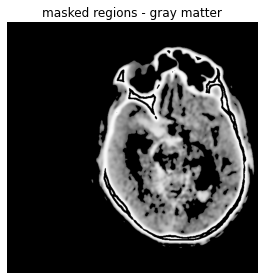

In [31]:
flat_mask = masked.flatten()
flat_mask = [i for i in flat_mask if i != 0]
max_intens = statistics.mode(flat_mask)
mask = (masked != max_intens)
gms2_im = masked*mask

flat_gms2 = gms2_im.flatten()
flat_mask = [i for i in flat_gms2 if i != 0]
max_intens = statistics.mode(flat_mask)
mask = (gms2_im != max_intens)
gms3_im = gms2_im*mask

plt.imshow(gms3_im, cmap = 'gray')
plt.title('masked regions - gray matter')
plt.axis('off')
plt.tight_layout()

## Adaptive thresholding exploration --> not used in analysis 

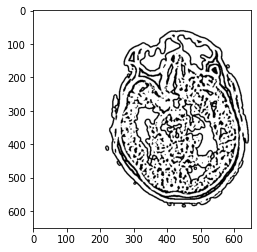

In [32]:
th3 = cv2.adaptiveThreshold(gms3_im,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,11,2)
plt.imshow(th3, cmap = 'gray')

# Analysis of Single CT Scan using  Multi Otsu

[ 37.35351562  98.11523438 147.91992188 205.69335938]
[205.69335938]


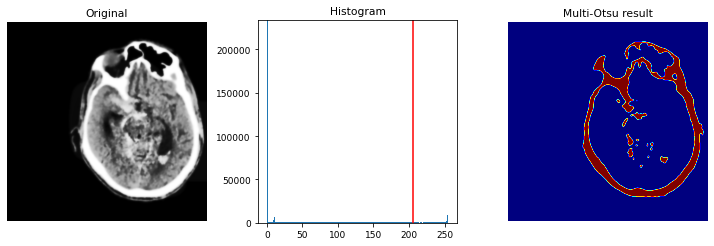

In [33]:
from skimage import data
from skimage.filters import threshold_multiotsu

# Setting the font size for all plots.
plt.rcParams['font.size'] = 9

image = ndimage.gaussian_filter(tv_im, 1)
# Applying multi-Otsu threshold for the default value, generating
# three classes.
thresholds = threshold_multiotsu(image, classes=5)
print(thresholds)
thresholds = thresholds[3:]
print(thresholds)
# Using the threshold values, we generate the three regions.
regions = np.digitize(image, bins=thresholds)
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Plotting the original image.
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Plotting the histogram and the two thresholds obtained from multi-Otsu.
ax[1].hist(image.ravel(), bins=255)
mode = statistics.mode(tv_im.flatten())
most = np.count_nonzero(tv_im == mode)

ax[1].set_ylim(top=most+1)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Plotting the Multi Otsu result.
ax[2].imshow(regions, cmap='jet')
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()
plt.tight_layout()
plt.show()

(-0.5, 649.5, 649.5, -0.5)

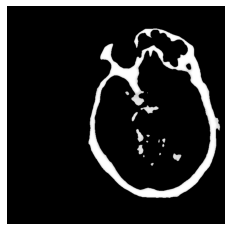

In [34]:
new = regions*tv_im
plt.imshow(new, 'gray')
plt.axis('off')

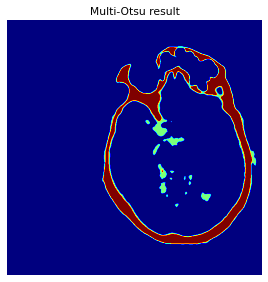

In [35]:
thresholds = threshold_multiotsu(new, classes=3)

regions = np.digitize(new, bins=thresholds)

# Plotting the Multi Otsu result.
plt.imshow(regions, cmap='jet')
plt.title('Multi-Otsu result')
plt.axis('off')
plt.tight_layout()
plt.show()

## Segment Bone
# the bone interferes a lot with analysis of brain matter, so we segmented it out 

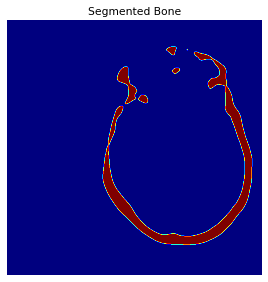

In [36]:
bone = ndimage.gaussian_filter(bone, 5)
thresholds = threshold_multiotsu(bone, classes=3)
thresholds = thresholds[1:]
bone_mask = np.digitize(bone, bins=thresholds)

# Plotting the Multi Otsu result.
plt.imshow(bone_mask, cmap='jet')
plt.title('Segmented Bone')
plt.axis('off')
plt.tight_layout()
plt.show()

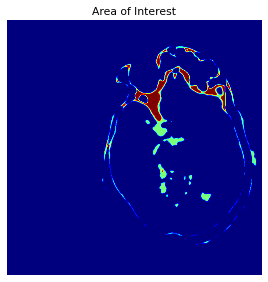

In [37]:
bone_mask=(bone_mask==0)
brain_no_bones = regions * bone_mask
plt.imshow(brain_no_bones, cmap='jet')
plt.title('Area of Interest')
plt.axis('off')
plt.tight_layout()
plt.show()

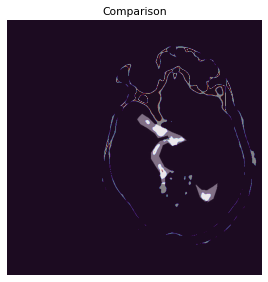

In [38]:
#overlaying our segmentation with theirs 
plt.imshow(brain_no_bones, cmap='twilight_shifted')
plt.imshow(answer, cmap = 'gray', alpha = 0.4)
plt.title('Comparison')
plt.axis('off')
plt.tight_layout()
plt.show()

# Accessing the Performance by Pixels

In [39]:
tn = 0
tp = 0
fn = 0
fp = 0
answer = cv2.cvtColor(answer, cv2.COLOR_BGR2GRAY)
for w in range(brain_no_bones.shape[0]): 
    for h in range(brain_no_bones.shape[1]): 
        if brain_no_bones[w,h] == 0 and answer[w,h] == 0: 
            tn += 1
        elif brain_no_bones[w,h] == 1 and answer[w,h] == 255: 
            tp += 1
        elif brain_no_bones[w,h] == 0 and answer[w,h] == 255: 
            fn += 1
        else: #brain_no_bones[w,h] == 1 and bones[w,h] == 0: 
            fp += 1
            

In [40]:
tn = tn/(bone.shape[0]*bone.shape[1])
tp = tp/(bone.shape[0]*bone.shape[1])
fn = fn/(bone.shape[0]*bone.shape[1])
fp = fp/(bone.shape[0]*bone.shape[1])

print(tn)
print(tp)
print(fn)
print(fp)

0.9545230769230769
0.004634319526627219
0.006875739644970414
0.033966863905325446


In [41]:
recall = tp/(tp+fn) # how often is it positive when it should be positive 
false_pos_rate = fp/(fp+tn) # how often is it wrong about being positive when it should be negative 
precision = tp/(tp+fp) # what is truely positive out of all positive 
import seaborn
data = [[tp, fp],[fn, tn]]
print(recall)
print(false_pos_rate)
print(precision)

0.4026321200904791
0.034362376896683006
0.12005641057085044


[Text(0.5, 16.0, 'Actual'),
 Text(34.0, 0.5, 'Predicted'),
 [Text(0.5, 0, 'Positive'), Text(1.5, 0, 'Negative')],
 [Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')],
 Text(0.5, 1.0, 'Confusion Matrix')]

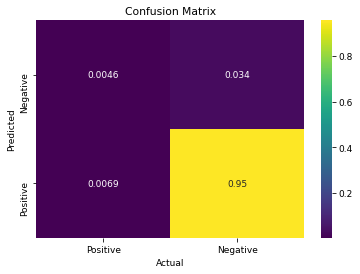

In [42]:
ax = seaborn.heatmap(data, annot = True, cmap = 'viridis')
ax.set(xlabel="Actual", ylabel="Predicted", xticklabels=['Positive', 'Negative'], 
       yticklabels=['Negative', 'Positive'], title = 'Confusion Matrix')


# End of Code